#### What we were doing last time

We need to run experiment p = 0.7
Don't bother plotting fmaps, it's useless to us.
Set up their text cells as we gain knowledge about their behaviour.

In training logs, we see that at most times, val accuracy is higher, and loss is lower than that of training, we could use that in our markdown files as an observation near the generalization error plot, it indicates the effects of regularization.

# Dropout in Fully Connected Layers

## Purpose
We test whether applying dropout to the **fully connected layers** reduces overfitting and improves generalization.  
This notebook compares FC dropout performance against the baseline.  

In [ ]:
!pip install thop

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/regularization-ml/


/content/drive/MyDrive/regularization-ml


In [ ]:
import torch
from PIL import Image

from config.paths import PathConfig # Path config

from src.model import MiniCNN, ConvBlock, FCBlock
from src.train import trainModel
from src.data import CustomDataset, load_cifar_10_data, check_data_loading, Loader, class_to_idx
from src.visualizations import plotFmaps_and_activationHist, plotCurves
from src.utils import EarlyStopping, unpickle, loadWeights, readJson, genError, saveHistory, evalModel

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
paths = PathConfig("regularization-ml", "regularization-data")
PROJECT_DIR = paths.project
DATA_DIR = paths.data
BASE_DIR = paths.root

In [ ]:
# Copy once from Drive
!cp $DATA_DIR/cifar-10-python.tar.gz /content/

# Extract locally
!mkdir /content/dataset/
!tar -xvzf /content/cifar-10-python.tar.gz -C /content/dataset/

## Model Definition
Baseline CNN + dropout in the fully connected layers.  
- Dropout probability tested: p ∈ {0.3, 0.5, 0.7}  
- Other architecture/hyperparameters unchanged.

Firstly, we test for p = 0.3.

### Dropout p = 0.3
We change the probability of dropout occuring in the fc layer to 0.3

In [ ]:
base_conv_layers = [
    ConvBlock(3, 64, pool=False),
    ConvBlock(64, 64),
    ConvBlock(64, 128, pool=False),
    ConvBlock(128, 128)
]

fc3_layer = [
    FCBlock(128, 64, True, 0.3),
    torch.nn.Linear(64, 10)
]

drop_3_model = MiniCNN(base_conv_layers, fc3_layer)

## Dataset
Same setup as baseline (CIFAR-10, normalized, no augmentations).  


In [ ]:
LOCAL_DATA = f"{BASE_DIR}/dataset" # path to cifar-10 dataset
train_data, train_labels, val_data, val_labels, test_data, test_labels = load_cifar_10_data(LOCAL_DATA)

In [ ]:
# Creates train, test, and val loaders
train_loader, val_loader, test_loader = Loader(train_data, train_labels, val_data, val_labels, test_data, test_labels)

Starting Data Loading...
✅ CUDA available: Tesla T4
   Memory: 15095 MB
📁 Loading datasets...
✅ Datasets loaded successfully
Training samples: 40000
Validation samples: 10000
Batch size: 64
🔍 Testing data loading...
✅ Train batch shape: torch.Size([64, 3, 32, 32]), Labels: torch.Size([64])
   Input range: [-1.989, 2.126]
   Label range: [0, 9]
✅ Val batch shape: torch.Size([64, 3, 32, 32]), Labels: torch.Size([64])


## Training Setup
Identical to baseline: AdamW, lr=0.01, decay_factor=0.01, lr annealing, batch_size=64, num_epochs dependent on early stopping. Patience is higher, raised to 10.

Only difference: dropout added after dense layers.

In [ ]:
"""
history_drop3 = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
model_type = "fc0.3"
path = f"{DATA_DIR}/weights"
fc3model = trainModel(drop_3_model, history_drop3, train_loader, val_loader, model_type, path, 10)
"""

'\nhistory_drop3 = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}\nmodel_type = "fc0.3"\npath = f"{DATA_DIR}/weights"\nfc3model = trainModel(drop_3_model, history_drop3, train_loader, val_loader, model_type, path, 10)\n'

In [ ]:
"""
history_path = f"{DATA_DIR}/logs/fc0.3.json"
saveHistory(history_drop3, history_path) # Saves the training metadata to a json file
"""

'\nhistory_path = f"{DATA_DIR}/logs/fc0.3.json"\nsaveHistory(history_drop3, history_path) # Saves the training metadata to a json file\n'

## Plots and Visualizations

In [ ]:
visuals_folder3 = f"{DATA_DIR}/visualizations/fc0.3"
weights_path = f"{DATA_DIR}/weights/fc0.3.pth"
fc3model = loadWeights(drop_3_model, weights_path)

In [ ]:
fc3_json = f"{DATA_DIR}/logs/fc0.3.json"
fc3_data = readJson(fc3_json) # method reads the training metadata from a json file.

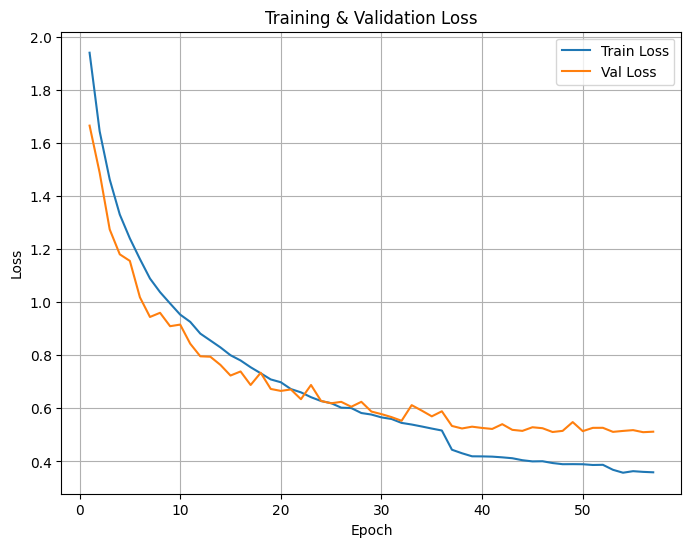

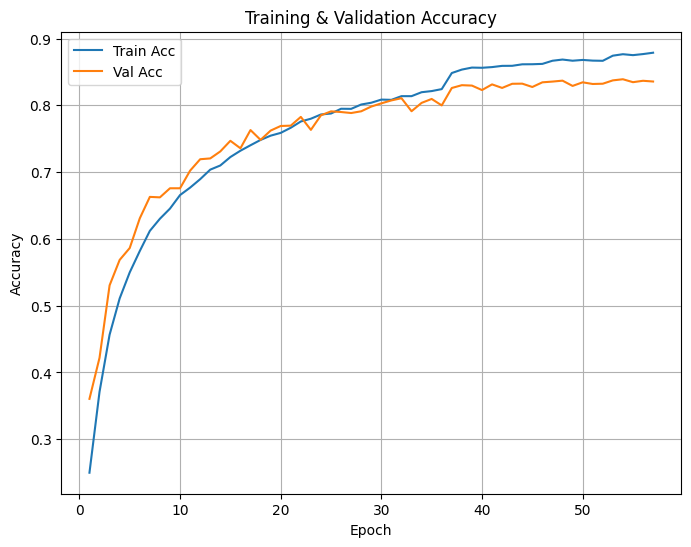

In [ ]:
train_losses = fc3_data["train_loss"]
val_losses = fc3_data["val_loss"]
train_accs = fc3_data["train_acc"]
val_accs = fc3_data["val_acc"]
plotCurves(train_losses, val_losses, train_accs, val_accs, visuals_folder3)

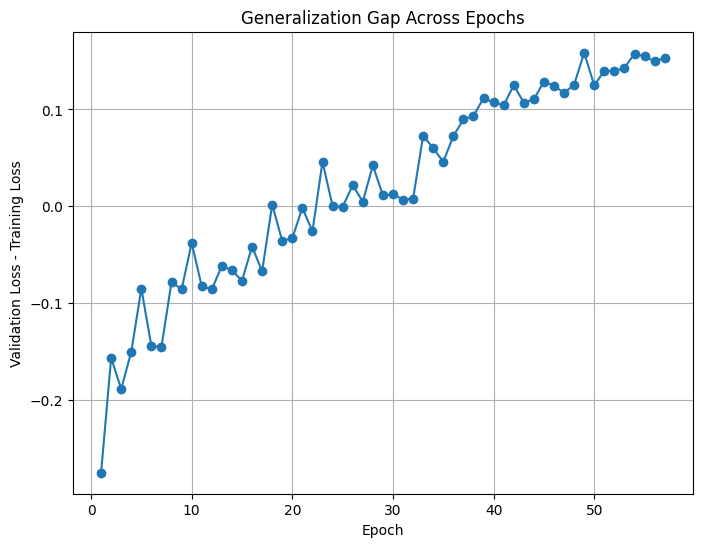

In [ ]:
genError(visuals_folder3, train_losses, val_losses)

Accuracy: 0.8168
              precision    recall  f1-score   support

           0     0.8020    0.8790    0.8387      1000
           1     0.8904    0.9260    0.9078      1000
           2     0.7455    0.7380    0.7417      1000
           3     0.6808    0.6590    0.6697      1000
           4     0.8149    0.7530    0.7827      1000
           5     0.7737    0.7350    0.7538      1000
           6     0.8140    0.8620    0.8373      1000
           7     0.8505    0.8420    0.8462      1000
           8     0.9036    0.8900    0.8967      1000
           9     0.8858    0.8840    0.8849      1000

    accuracy                         0.8168     10000
   macro avg     0.8161    0.8168    0.8160     10000
weighted avg     0.8161    0.8168    0.8160     10000

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequenti

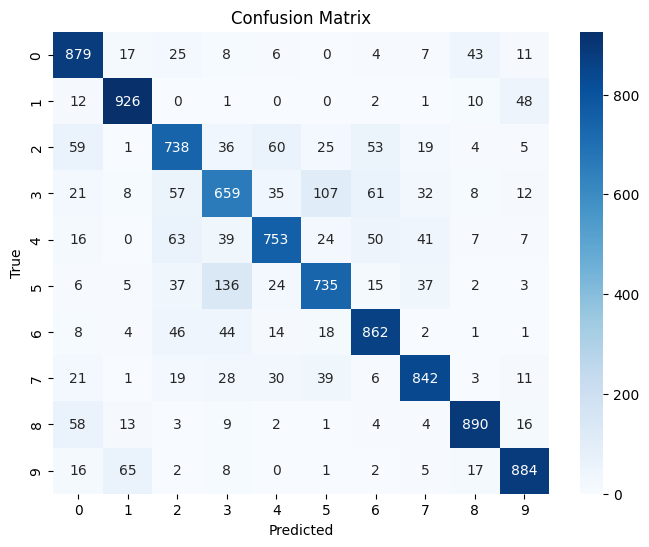

In [ ]:
evalModel(fc3model, visuals_folder3, test_loader)

### Dropout p = 0.5

In [ ]:
# p = 0.5 in the model definition.
fc5_layer = [
    FCBlock(128, 64, True, 0.5),
    torch.nn.Linear(64, 10)
]

drop_5_model = MiniCNN(base_conv_layers, fc5_layer)

In [ ]:
history_drop5 = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
model_type = "fc0.5"
path = f"{DATA_DIR}/weights"
fc5model = trainModel(drop_5_model, history_drop5, train_loader, val_loader, model_type, path, 10)

In [30]:
history_path5 = f"{DATA_DIR}/logs/fc0.5.json"
saveHistory(history_drop5, history_path5) # Saves the training metadata to a json file

File Saved!
